In [1]:
%pip install -U textblob
!python -m textblob.download_corpora

%pip install nltk

%pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package brown to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finis

In [2]:
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

import gensim
from gensim.models import Word2Vec

from datetime import datetime

In [3]:
def str_to_timestamp(s):
    out=[]

    s2=str.split(s,'+')
    s3=str.split(s2[0],' ')

    s4=str.split(s3[0],'-')

    s5=str.split(s3[1],':')
    year=int(s4[0])
    month=int(s4[1])
    day=int(s4[2])
    hour=int(s5[0])
    minute=int(s5[1])
    second=int(s5[2])

    return(datetime(year=year,month=month,day=day,hour=hour,minute=minute,second=second).timestamp())

from nltk.tokenize import word_tokenize

def NumStr(mot):
    res = ''.join(filter(lambda i: i.isdigit(), mot))
    if (res==''):
        return False
    return True


def extract_keywords(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Apply part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Select only nouns and adjectives
    keywords = [word for word, pos in tagged_tokens if (pos in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'] and not NumStr(word))]

    return keywords

def extract_sentiment_polarity(text):
    blob=TextBlob(text)
    return(blob.sentiment.polarity)

In [5]:
data=pd.read_csv('data/minnesota.csv')
df=data
print('start')

df['keywords'] = df['tweet_text'].apply(extract_keywords)

print('end of keywords')

df['sentiment_polarity']=df['tweet_text'].apply(extract_sentiment_polarity)

print('end of polarity')

df['timestamps']=df['tweet_created_dt'].apply(str_to_timestamp)
df['timestamps']=df['timestamps']-df['timestamps'].min()

print('end of timestamps')

clean_data=df

start
end of keywords
end of polarity
end of timestamps


In [6]:
model = Word2Vec(sentences=data['keywords'], vector_size=100, window=5, min_count=2, workers=4)
model.save("word2vec.model")
word_vectors = model.wv
del model

def word2vectors(l):
    try:
        x = word_vectors[l]
    except KeyError:
        return 
    return x
    

def list2vectors(L):
    out=[]
    for i in L:
        out.append(word2vectors(i))
    return(np.asarray(out,dtype=object))

In [7]:
clean_data['vectors']=clean_data['keywords'].apply(list2vectors)

In [8]:
L=[]
for keywords in clean_data[clean_data['sentiment_polarity']<0]['keywords']:
    for words in keywords:
        L.append(words)
len(L)
word_hist=pd.value_counts(np.array(L))
word_hist[0:100]

black               73106
matter              45858
lives               36170
i                   30540
blacklivesmatter    28183
                    ...  
others               1189
system               1188
sick                 1182
words                1174
state                1169
Length: 100, dtype: int64

In [9]:
L=[]
for keywords in clean_data['keywords']:
    for words in keywords:
        L.append(words)
print(len(L))
word_hist=pd.value_counts(np.array(L))
print(word_hist[0:100]/len(word_hist))
print(len(word_hist))

3082858
blacklivesmatter    0.950360
black               0.759869
i                   0.569869
matter              0.472007
floyd               0.420755
                      ...   
matters             0.023009
words               0.022785
riots               0.022705
let                 0.022662
color               0.022597
Length: 100, dtype: float64
138337


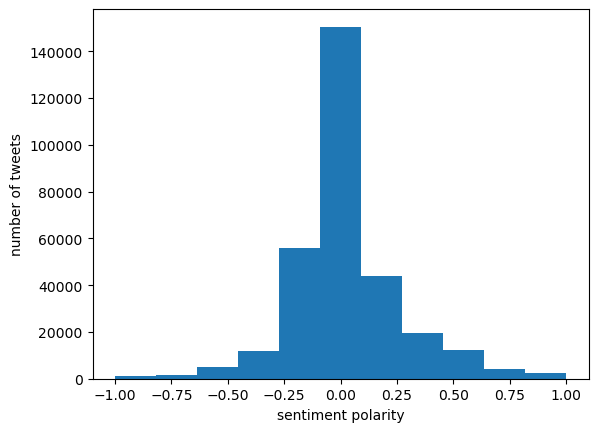

0.02349505636721162

In [18]:
plt.hist(clean_data['sentiment_polarity'],bins=11)
plt.xlabel('sentiment polarity')
plt.ylabel('number of tweets')
plt.savefig("figures_out/fig_sentiment_pol.png",transparent=True)
plt.show()
clean_data['sentiment_polarity'].mean()

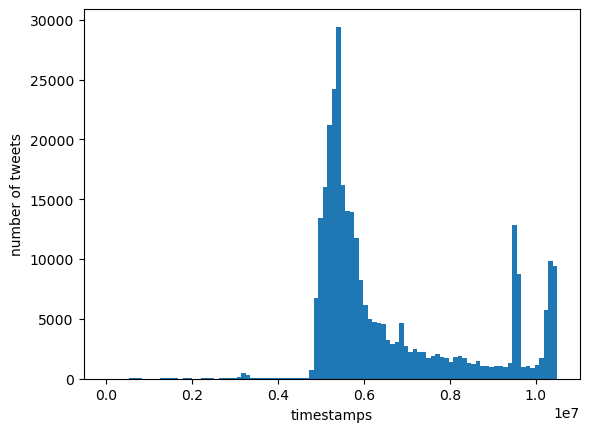

In [11]:
plt.hist(clean_data['timestamps'],bins=100)
plt.xlabel('timestamps')
plt.ylabel('number of tweets')
plt.savefig("figures_out/fig_timestamps.png",transparent=True)
plt.show()

In [12]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

4856398.67768595

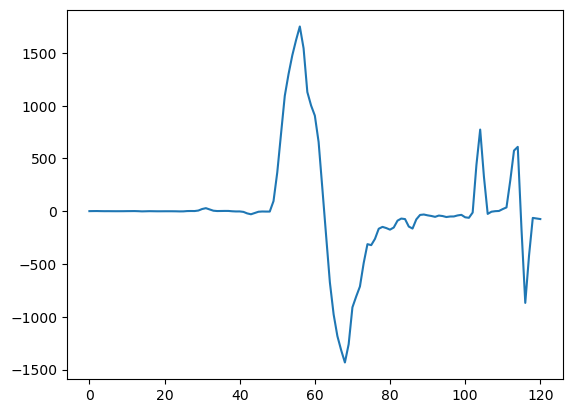

In [13]:
time_day=60*60*24
nb_bins=int(clean_data['timestamps'].max()/time_day)
coef_smooth=int(nb_bins/10)

hist,e=np.histogram(clean_data['timestamps'],nb_bins)
smooth_hist=smooth(hist,coef_smooth)
x_hist=range(nb_bins)
dhist=np.gradient(smooth_hist,x_hist)
plt.plot(x_hist,dhist)
the_time=e[dhist.argmax()]
before_the_time=the_time-time_day
the_time

In [14]:
before=clean_data[clean_data['timestamps']<the_time]
before['sentiment_polarity'].mean()

-0.033675001731679345

[]

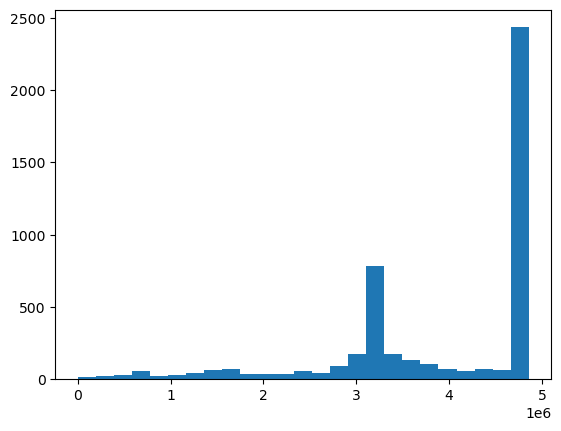

In [15]:
plt.hist(before['timestamps'],bins='auto')
plt.plot()

In [16]:
L=[]
for keywords in before['keywords']:
    for words in keywords:
        L.append(words)
len(L)
word_hist=pd.value_counts(np.array(L))
word_hist[0:50]

blacklivesmatter          1924
black                     1782
i                         1484
georgefloyd                962
matter                     759
george                     717
floyd                      712
lives                      683
people                     664
police                     538
white                      434
man                        405
blacklivesmatters          351
justice                    318
icantbreathe               303
murder                     299
confusion                  250
video                      247
minneapolis                237
life                       227
death                      208
today                      201
officers                   199
cops                       196
justiceforgeorgefloyd      190
racism                     168
america                    166
nan                        161
name                       160
irunwithmaud               159
men                        155
time                       154
justicef

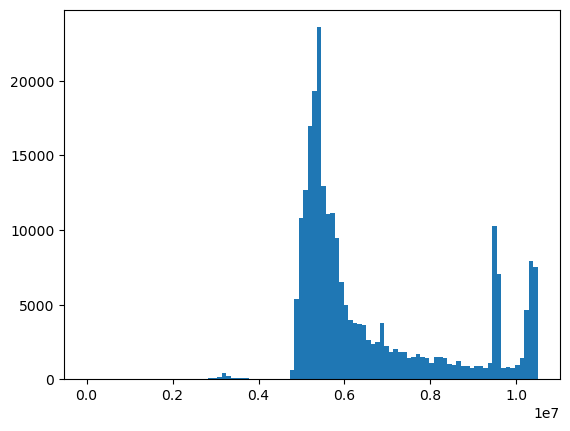

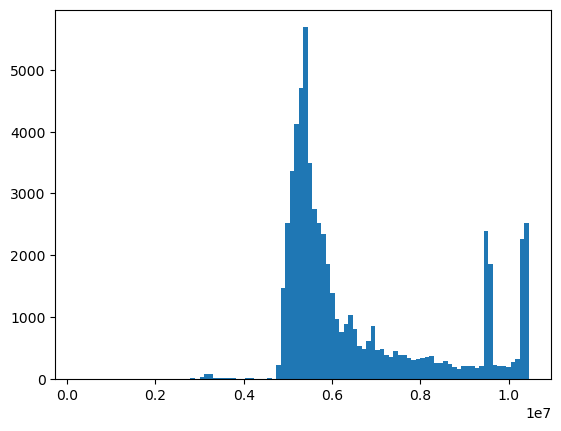

In [17]:
train_split=clean_data.sample(frac=.8)
test_split=clean_data.drop(train_split.index)
plt.figure()
plt.hist(train_split['timestamps'],bins=100)
plt.show()

plt.figure()
plt.hist(test_split['timestamps'],bins=100)
plt.show()